# Create import/export price data
We select a TOU structure with low-price period at night and high-price period at evening. Remainder of the day is middle-price. We set the battery degradation to be 0.084€/kWh discharged. 

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


In [2]:
# Create TOU price file for full year 2020 in 15-min intervals.
# Prices are defined in **German local time (Europe/Berlin)** but timestamps are saved/displayed in **UTC**.

def tou_prices(t0=[0,6], t1=[6,17], t2=[17,21], t3=[21,24], p1=[0.2, 0.07], p2=[0.3, 0.1], p3=[0.4, 0.18]):

    # 1) Build a UTC index covering all of 2020 in 15-min steps
    idx_utc = pd.date_range("2020-01-01 00:00:00", "2021-01-01 00:00:00", freq="15min", tz="UTC", inclusive="left")

    # 2) Convert to German local time for assigning TOU bands
    idx_local = idx_utc.tz_convert("Europe/Berlin")
    hours = idx_local.hour

    # 3) Create price arrays based on local time windows
    import_price = np.where(
        (hours >= t0[0]) & (hours < t0[1]) | (hours >= t3[0]),
        p1[0],
        np.where((hours >= t1[0]) & (hours < t1[1]), p2[0],
                np.where((hours >= t2[0]) & (hours < t2[1]), p3[0], p1[0]))
    )

    export_price = np.where(
        (hours >= t0[0]) & (hours < t0[1]) | (hours >= t3[0]),
        p1[1],
        np.where((hours >= t1[0]) & (hours < t1[1]), p2[1],
                np.where((hours >= t2[0]) & (hours < t2[1]), p3[1], p1[1]))
    )

    # 4) Assemble DataFrame with UTC timestamps
    df = pd.DataFrame({
        "timestamp": idx_utc,
        "import_price": import_price,
        "export_price": export_price
    }).set_index("timestamp")
    return df

In [ ]:
df_tou = tou_prices()
#df_tou.to_csv('tou_prices.csv')

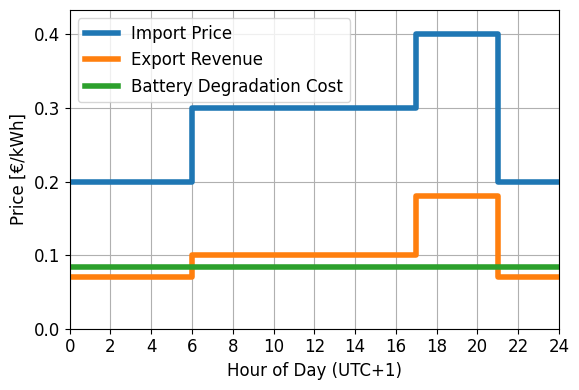

In [4]:
# plot one day of the tou prices for paper
df_tou_day = df_tou.loc["2020-01-01"]
c_deg = 0.084  # battery degradation cost in EUR/kWh

df_tou_day.index = df_tou_day.index.hour
df_tou_day = df_tou_day[~df_tou_day.index.duplicated(keep='first')]

# shift all values one step ahead since I want to display it not in UTC but in local time (UTC+1)
df_tou_day.index = df_tou_day.index + 1
df_tou_day.index = df_tou_day.index % 24
df_tou_day = df_tou_day.sort_index()

df_tou_day = pd.concat([
    df_tou_day,
    pd.DataFrame({'import_price': df_tou_day['import_price'].iloc[-1],
                  'export_price': df_tou_day['export_price'].iloc[-1],
                  'c_bat_deg': c_deg},
                 index=[24])
])

plt.figure(figsize=(6, 4))

plt.step(df_tou_day.index, df_tou_day['import_price'], where='post', label='Import Price', linewidth=4)
plt.step(df_tou_day.index, df_tou_day['export_price'], where='post', label='Export Revenue', linewidth=4)
plt.step(df_tou_day.index, [c_deg]*25, where='post', label='Battery Degradation Cost', linewidth=4)
plt.xlabel('Hour of Day (UTC)')
plt.ylabel('Price (EUR/kWh)')
plt.xlim(0, 24)

fontsize=12

plt.xticks(range(0, 25, 2), fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Hour of Day (UTC+1)', fontsize=fontsize)
plt.ylabel('Price [€/kWh]', fontsize=fontsize)

plt.legend(fontsize=fontsize, loc='upper left')
plt.grid()
plt.tight_layout()
plt.ylim(0.0, 0.433)
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4], fontsize=fontsize)
#plt.savefig('tou-prices-small.pdf')
plt.show()
